# Import des librairies nécessaires

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-traitement des données

## Ouverture du jeu de données et informations générales

In [11]:
data = pd.read_csv("fetal_health.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

Ici l'on peut voir que pandas interpréte correctement les différents types de données, sauf pour *fetal_health* qui dans notre cas devrait être catégorielle et ordonnée (3 est plus grave que 2 qui est plus grave que 1)

## Conversion de la variable *fetal_health* en variable qualitative ordinale

In [14]:
data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   baseline value                                          2126 non-null   float64 
 1   accelerations                                           2126 non-null   float64 
 2   fetal_movement                                          2126 non-null   float64 
 3   uterine_contractions                                    2126 non-null   float64 
 4   light_decelerations                                     2126 non-null   float64 
 5   severe_decelerations                                    2126 non-null   float64 
 6   prolongued_decelerations                                2126 non-null   float64 
 7   abnormal_short_term_variability                         2126 non-null   float64 
 8   mean_value_of_short_term_var

## Affichage du nombre de valeurs différentes et du nombre de valeurs manquantes

In [15]:
print(f"Nombre de valeurs différentes par variables :\n{data.nunique()}")
print()
print(f"Nombre de valeurs manquantes par variables :\n{data.isna().sum()}")

Nombre de valeurs différentes par variables :
baseline value                                             48
accelerations                                              20
fetal_movement                                            102
uterine_contractions                                       16
light_decelerations                                        16
severe_decelerations                                        2
prolongued_decelerations                                    6
abnormal_short_term_variability                            75
mean_value_of_short_term_variability                       57
percentage_of_time_with_abnormal_long_term_variability     87
mean_value_of_long_term_variability                       249
histogram_width                                           154
histogram_min                                             109
histogram_max                                              86
histogram_number_of_peaks                                  18
histogram_number_of_zero

Ici on voit qu'aucune variable n'est constante (aucune variable n'a qu'une seule et unique valeur), et l'on remarque aussi que le jeu de données ne contient aucune valeurs vides, ce qui nous arrange pour la suite.

# Exploration et visualisation des données

## Effectifs de chaque classe

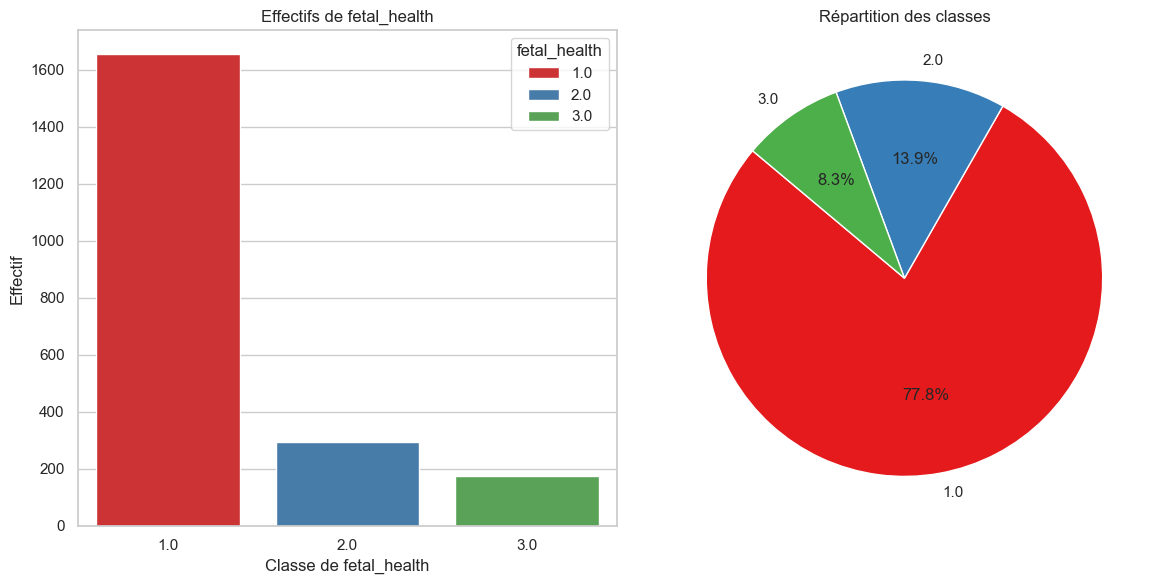

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x='fetal_health', hue="fetal_health", palette="Set1", data=data, ax=axes[0])
axes[0].set_title('Effectifs de fetal_health')
axes[0].set_xlabel('Classe de fetal_health')
axes[0].set_ylabel('Effectif')

plt.pie(pourcentages, labels=pourcentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
axes[1].set_title('Répartition des classes')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

On remarque un certain déséquilibre dans les classes de *fetal_health*, ce qui est normal.

# Histogrammes de chaque variable avec decoupage en fonction de la classe

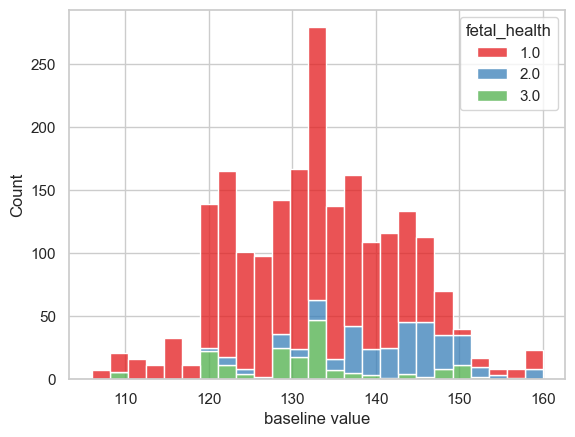

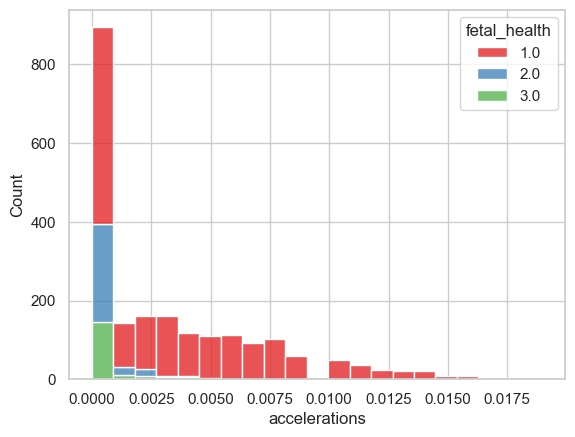

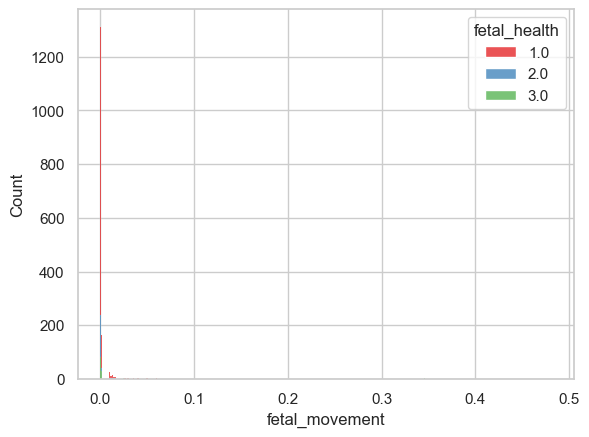

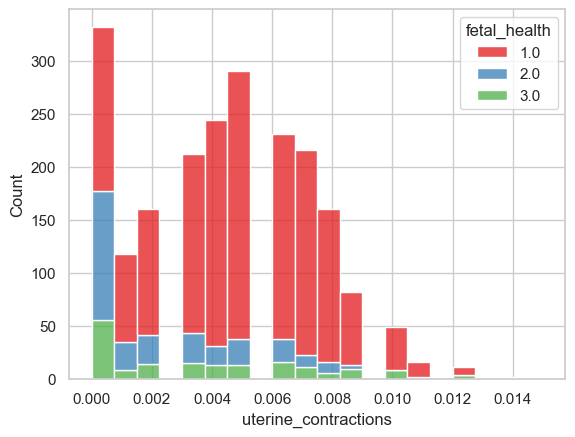

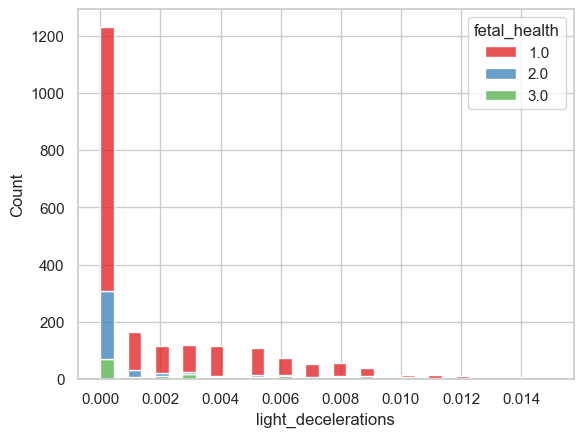

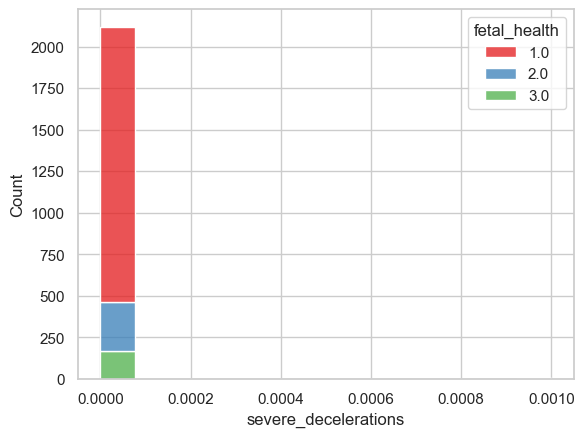

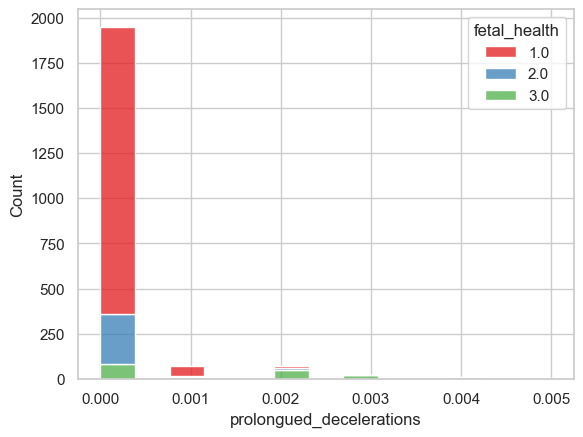

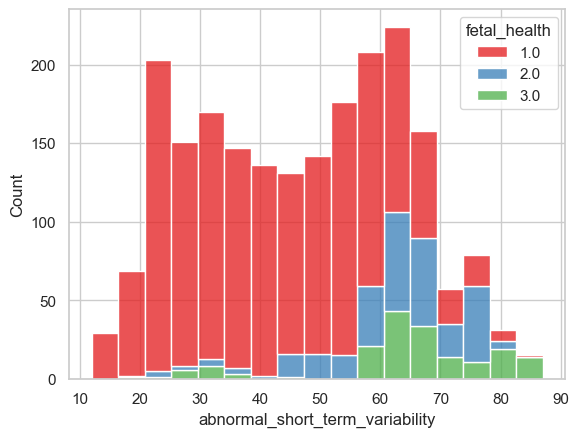

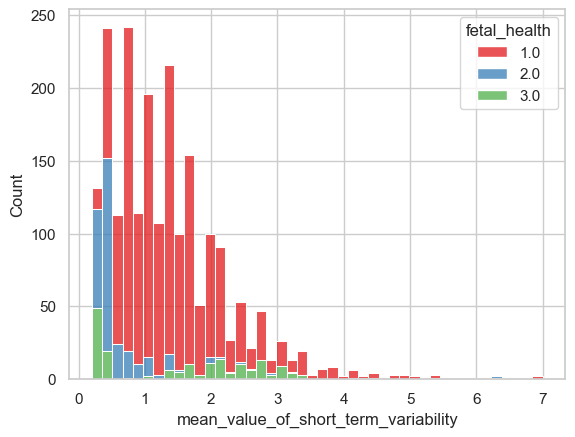

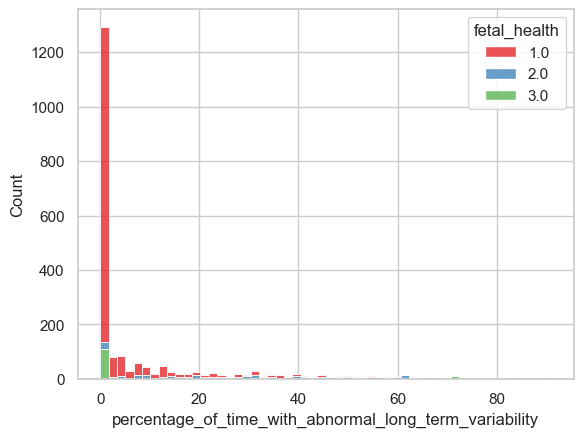

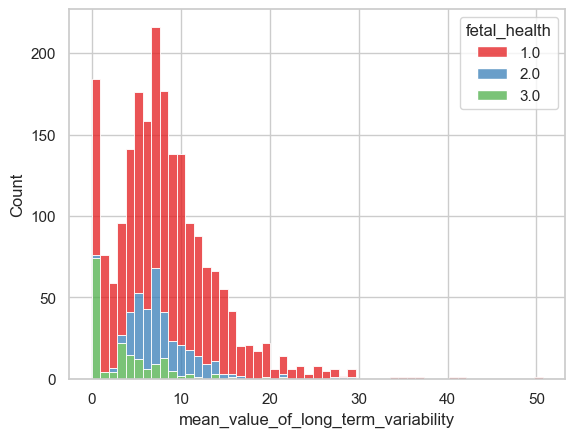

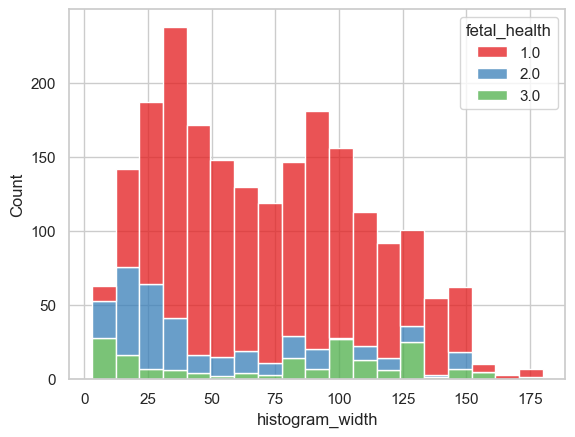

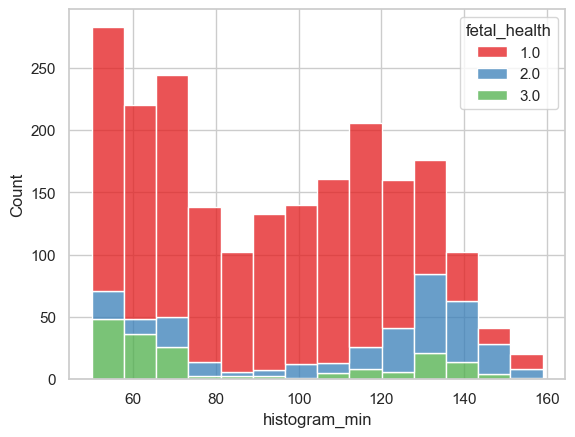

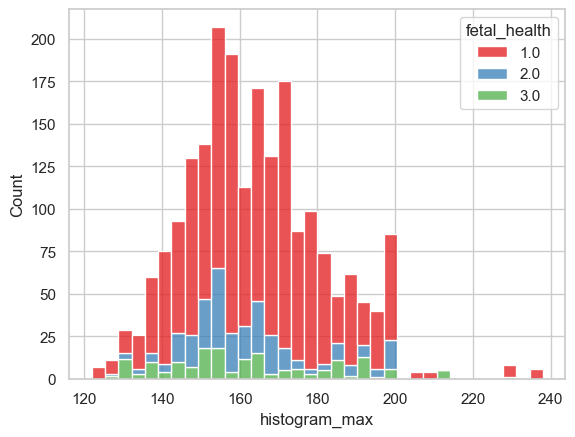

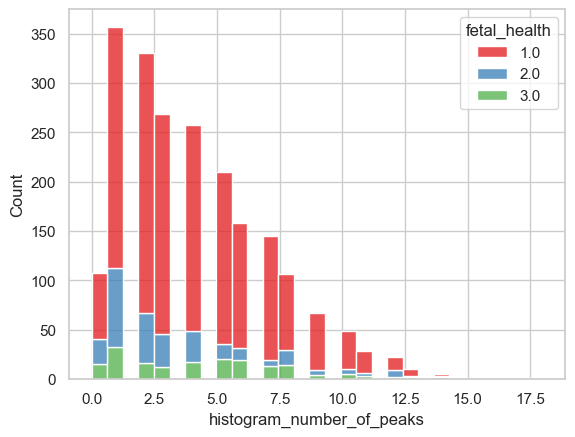

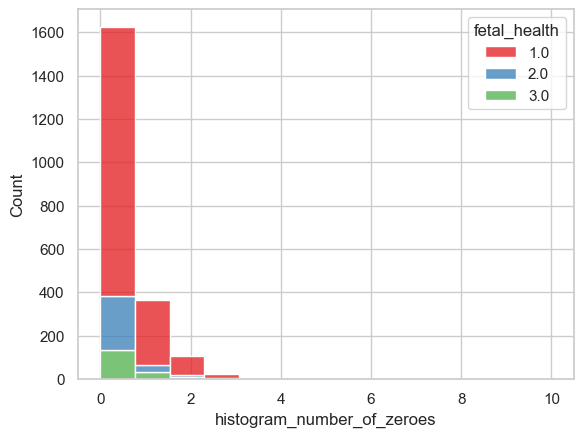

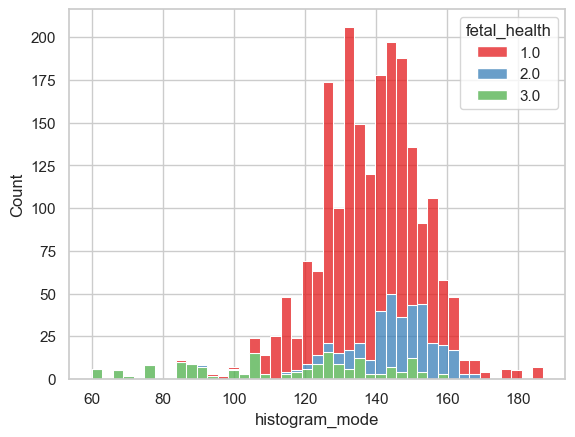

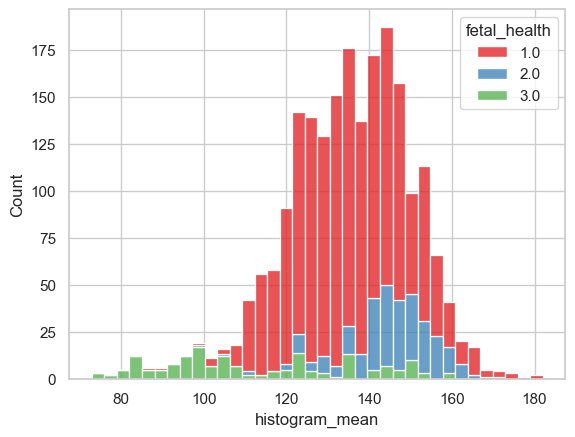

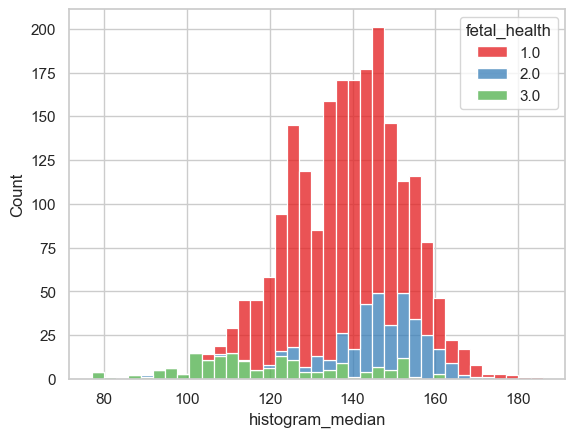

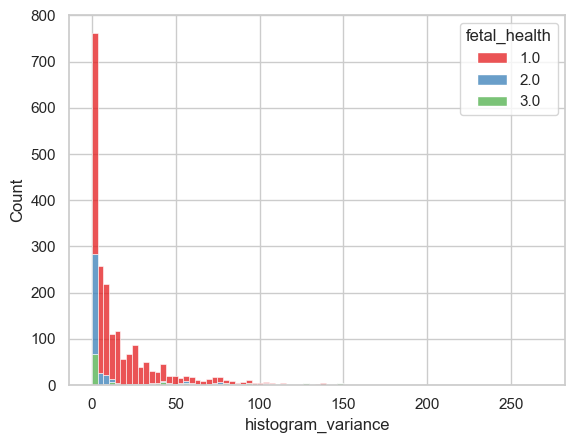

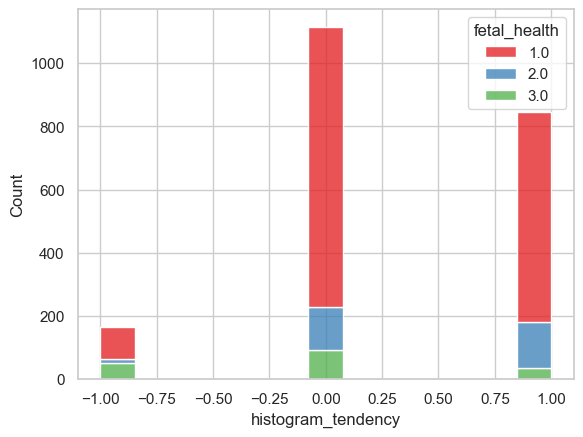

In [44]:
for column in data.columns:
    if column != "fetal_health":
        sns.histplot(x=column, hue="fetal_health", multiple="stack", palette="Set1", data=data)
        plt.show()

# Calcul de corrélations

## Matrice de corrélation

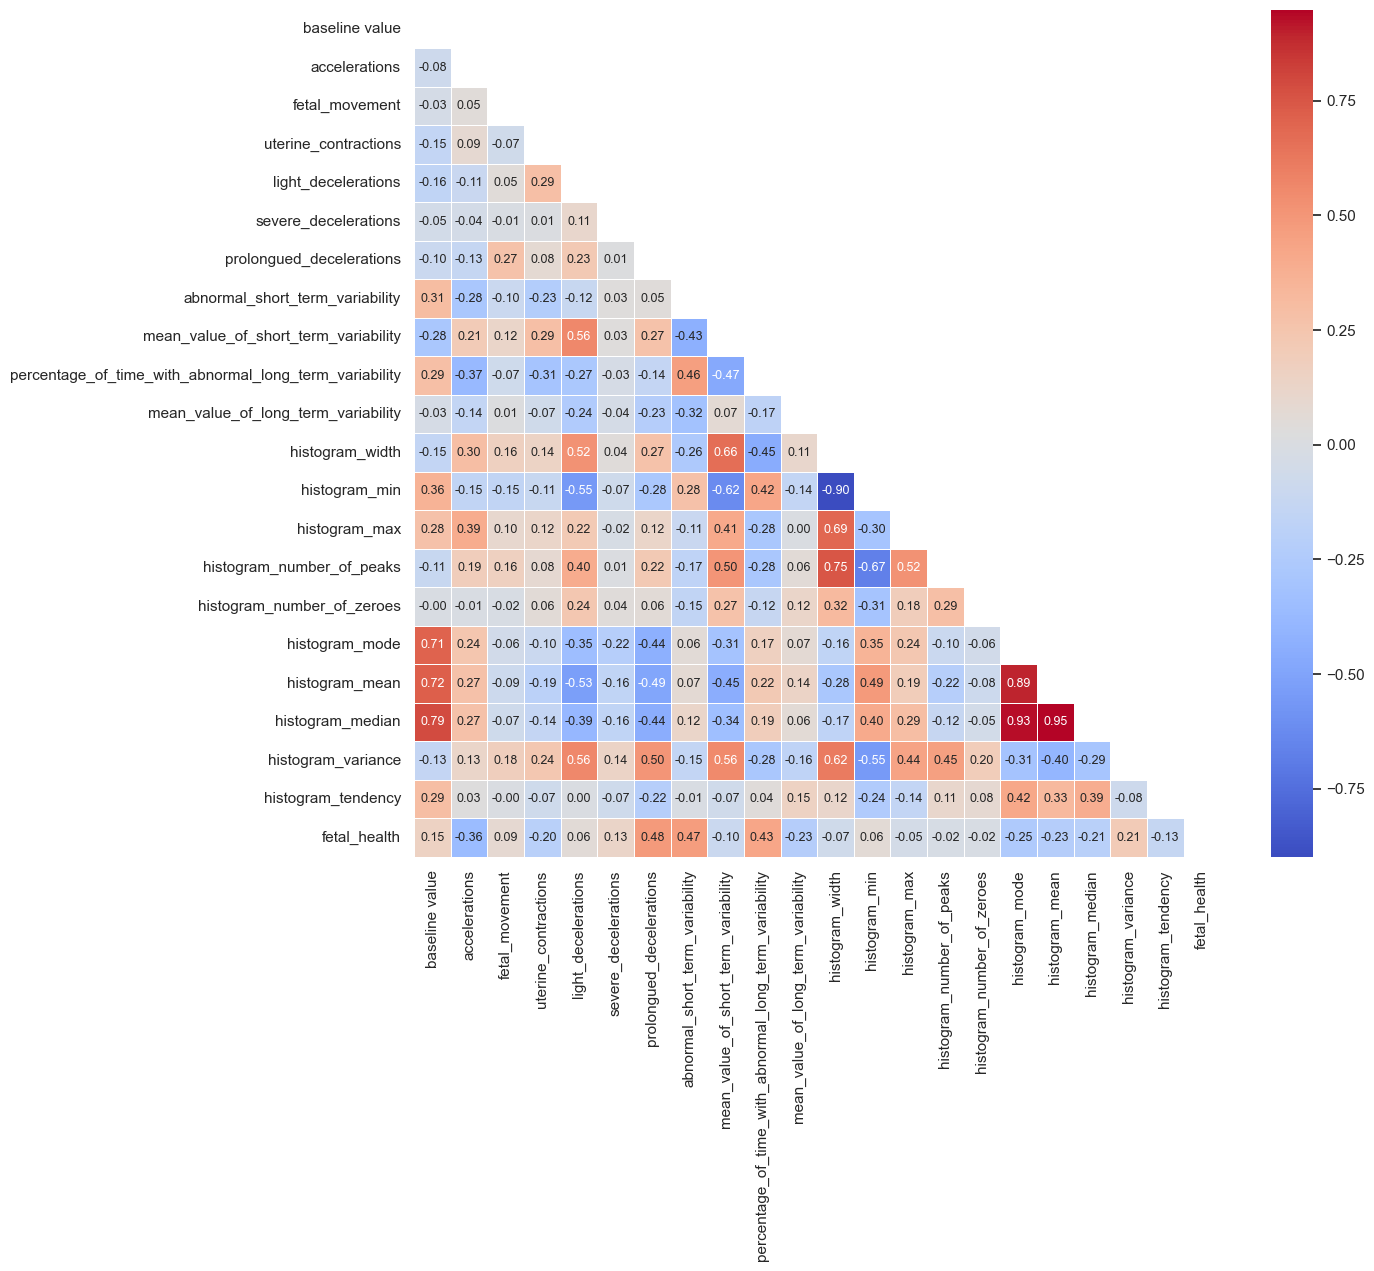

In [62]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(13, 11))
plt.grid(False)
sns.heatmap(corr, mask=mask, cmap='coolwarm', linewidths=0.5, annot=True, annot_kws={"fontsize":9}, fmt='.2f')
plt.show()